In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import os
import re
import copy
import json

In [89]:
PIECES_TO_NUM = {
    "square": 0,
    "white_pawn": 1,
    "white_rook": 2,
    "white_knight": 3,
    "white_bishop": 4,
    "white_king": 5,
    "white_queen": 6,
    "white_unknown": 7,
    "black_pawn": -1,
    "black_rook": -2,
    "black_knight": -3,
    "black_bishop": -4,
    "black_king": -5,
    "black_queen": -6,
    "black_unknown": -7,
}

NUM_TO_PIECE = {
    0: "square",
    1: "white_pawn",
    2: "white_rook",
    3: "white_knight",
    4: "white_bishop",
    5: "white_king",
    6: "white_queen",
    7: "white_unknown",
    -1: "black_pawn",
    -2: "black_rook",
    -3: "black_knight",
    -4: "black_bishop",
    -5: "black_king",
    -6: "black_queen",
    -7: "black_unknown"
}

In [90]:
piece_images = {
    piece: Image.open(f'assets/{piece}.png') for piece in PIECES_TO_NUM.keys() if piece != "square"
}

In [119]:
game_state = np.array([
    [-2, -3, -4, -6, -5, -4, -3, -2],
    [-1, -1, -1, -1, -1, -1, -1, -1],
    [ 0,  0,  0,  0,  0,  0,  0,  -7],
    [ 0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  7],
    [ 1,  1,  1,  1,  1,  1,  1,  1],
    [ 2,  3,  4,  6,  5,  4,  3,  2],
])

def draw_chessboard(board, save=False, show=False):
    board = np.flipud(board)
    fig, ax = plt.subplots()

    chessboard_pattern = np.zeros((8, 8))
    chessboard_pattern[1::2, ::2] = 1
    chessboard_pattern[::2, 1::2] = 1

    ax.imshow(chessboard_pattern, cmap='gray', interpolation='none')

    for i in range(8):
        for j in range(8):
            piece_value = board[i, j]
            if piece_value != 0:
                piece_name = NUM_TO_PIECE[piece_value]
                piece_image = piece_images[piece_name]
                ax.imshow(piece_image, extent=[j - 0.5, j + 0.5, i - 0.5, i + 0.5])

    ax.set_xticks(np.arange(8))
    ax.set_yticks(np.arange(8))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks(np.arange(-0.5, 8, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 8, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=2)

    if save:
        fig.savefig(f"{save}.png")

    if show: plt.show()
    
    matplotlib.pyplot.close()
    
draw_chessboard(game_state)


In [2]:
def modify_game_state(game_state, move):
    new_game_state = copy.copy(np.flipud(game_state)) # A1 is 0,0
    if " -> " in move:
        init_pos = move.split(" -> ")[0]
        new_pos = move.split(" -> ")[1]

        init_y_pos = int(init_pos[-1]) - 1
        init_x_pos = int(ord(init_pos[-2]) - 96 - 1)

        new_y_pos = int(new_pos[-1]) - 1
        new_x_pos = int(ord(new_pos[-2]) - 96 - 1)      

        piece = new_game_state[init_y_pos, init_x_pos]
        new_game_state[init_y_pos, init_x_pos] = 0
        new_game_state[new_y_pos, new_x_pos] = piece

    elif " + " in move:
        init_pos = move.split(" + ")[0]
        new_pos = move.split(" + ")[1]

        init_y_pos = int(init_pos[-1]) - 1
        init_x_pos = int(ord(init_pos[-2]) - 96 - 1)

        new_y_pos = int(new_pos[-1]) - 1
        new_x_pos = int(ord(new_pos[-2]) - 96 - 1)      

        piece = new_game_state[init_y_pos, init_x_pos]
        new_game_state[init_y_pos, init_x_pos] = 0
        new_game_state[new_y_pos, new_x_pos] = piece

    elif " x " in move:
        init_pos = move.split(" x ")[0]
        new_pos = move.split(" x ")[1]

        init_y_pos = int(init_pos[-1]) - 1
        init_x_pos = int(ord(init_pos[-2]) - 96 - 1)

        new_y_pos = int(new_pos[-1]) - 1
        new_x_pos = int(ord(new_pos[-2]) - 96 - 1)      

        piece = new_game_state[init_y_pos, init_x_pos]
        new_game_state[init_y_pos, init_x_pos] = 0
        new_game_state[new_y_pos, new_x_pos] = piece

    elif "O-O-O" in move:
        if move[0] == "w":
            new_game_state[0, 2] = new_game_state[0, 4]
            new_game_state[0, 3] = new_game_state[0, 0]
            new_game_state[0, 0] = 0
            new_game_state[0, 4] = 0
        else:
            new_game_state[7, 2] = new_game_state[7, 4]
            new_game_state[7, 3] = new_game_state[7, 0]
            new_game_state[7, 0] = 0
            new_game_state[7, 4] = 0

    elif "O-O" in move:
        if move[0] == "w":
            new_game_state[0, 6] = new_game_state[0, 4]
            new_game_state[0, 5] = new_game_state[0, 7]
            new_game_state[0, 7] = 0
            new_game_state[0, 4] = 0
        else:
            new_game_state[7, 6] = new_game_state[7, 4]
            new_game_state[7, 5] = new_game_state[7, 7]
            new_game_state[7, 7] = 0
            new_game_state[7, 4] = 0
        

    return np.flipud(new_game_state)

In [5]:
# "->" is a move
# "x" is a capture
# "+" is check
# "#" is checkmate
# "O-O" is kingside castle
# "O-O-O" is queenside castle
example_game = [
    "Ng1 -> Nf3",
    "d7 -> d5",
    "g2 -> g3",
    "c7 -> c5",
    "Bf1 -> Bg2",
    "Nb8 -> Nc6",
    "wO-O",
    "e7 -> e5",
    "d2 -> d3",
    "Bf8 -> Be7",
    "e2 -> e4",
    "d5 -> d4",
    "Nb1 -> Nd2",
    "h7 -> h5",
    "Nd2 -> Nc4",
    "Qd8 -> Qc7",
    "a2 -> a4",
    "h5 -> h4",
    "Nf3 x Nh4",
    "Be7 x Bh4",
    "g3 x h4",
    "Bc8 -> be6",
    "f2 -> f4",
    "Be6 x Bc4",
    "d3 x c4",
    "Qc7 -> Qe7",
    "Ra1 -> Ra3",
    "Rh8 x Rh4",
    "Ra3 -> Rg3",
    "Ng8 -> Nf6",
    "f4 x e5",
    "Nc6 x Ne5",
    "Rg3 x Rg7",
    "Qe7 -> Qf8",
    "Rg7 -> Rg5",
    "Nf6 -> Nd7",
    "Bc1 -> Bf4",
    "Qf8 -> Qh8",
    "Qd1 -> Qe1",
    "f7 -> f6",
    "Bf4 x Be5",
    "Nd7 x Ne5",
    "Rf1 x Rf6",
    "Ne5 x Nc4",
    "Rf6 -> Rg6",
    "Ke8 -> Kd7",
    "Rg6 + Rg7",
    "Kd7 -> Kc6",
    "Rg5 + Rg6",
    "Nc4 -> Nd6",
    "e4 -> e5"
]

game = [
    "d2 -> d4", "d7 -> d5",
    "c2 -> c4", "e7 -> e6",
    "Ng1 -> Nf3", "Ng8 -> Nf6",
    "Nb1 -> Nc3", "c7 -> c6",
    "Bc1 -> Bg5", "d5 x c4",
    "e2 -> e4", "b7 -> b5",
    "e4 -> e5", "h7 -> h6",
    "Bg5 -> Bh4", "g7 -> g5",
    "Nf3 x g5", "h6 x g5",
    "Bh4 x g5", "Bf8 -> e7",
    "e5 x f6", "Be7 x f6",
    "Bg5 x f6", "Qd8 x f6",
    "a2 -> a4", "Rh8 -> h4",
    "g2 -> g4", "Qf6 -> g7",
    "h2 -> h3", "e6 -> e5",
    "Bf1 -> g2", "e5 x d4",
    "Nc3 x b5", "c6 x b5",
    "Bg2 x a8", "b5 -> b4",
    "Qd1 -> e2", "Bc8 -> e6",
    "Ba8 -> d5", "d4 -> d3",
    "Qe2 -> e4", "d3 -> d2",
    "Ke1 -> e2", "Qg7 x b2",
    "Ra1 -> d1", "c4 -> c3",
    "Bd5 x e6", "f7 x e6",
    "Qe4 x e6", "Ke8 -> d8",
    "Qe6 -> f6", "Kd8 -> c8",
    "Qf6 x h4", "c3 -> c2",
    "Rd1 x d2", "Qb2 -> e5",
    "Ke2 -> f3", "Qe5 -> c3",
    "Kf3 -> e2", "Qc3 -> e5"
]

moving_game = [
    "d2 -> d4", "Ng8 -> Nf6",
    "c2 -> c4", "e7 -> e6",
    "Nb1 -> Nc3", "Bf8 -> b4",
    "f2 -> f3", "d7 -> d5",
    "a2 -> a3", "Bb4 x c3",
    "b2 x c3", "c7 -> c5",
    "c4 x d5", "e6 x d5",
    "e2 -> e3", "Bc8 -> f5",
    "Ng1 -> e2", "bO-O",
    "g2 -> g4", "Bf5 -> g6",
    "Ne2 -> f4", "Nb8 -> c6",
    "Bf1 -> g2", "Ra8 -> c8",
    "wO-O", "Nc6 -> a5",
    "Ra1 -> a2", "h7 -> h6",
    "Nf4 x g6", "f7 x g6",
    "Rf1 -> e1", "Rc8 -> c6",
    "Ra2 -> f2", "c5 x d4",
    "c3 x d4", "Qd8 -> b6",
    "Rf2 -> b2", "Qb6 -> c7",
    "e3 -> e4", "Kg8 -> h8",
    "e4 -> e5", "Nf6 -> g8",
    "f3 -> f4", "Ng8 -> e7",
    "Rb2 -> b1", "Na5 -> c4",
    "Qd1 -> d3", "Nc4 -> b6",
    "Bc1 -> d2", "Nb6 -> c4",
    "Bd2 -> c1", "Nc4 -> b6",
    "Bc1 -> d2", "Nb6 -> c4",
    "Bd2 -> b4", "Rf8 -> d8",
    "Re1 -> f1", "Rc6 -> b6",
    "f4 -> f5", "g6 x f5",
    "g4 x f5", "Ne7 -> c6",
    "f5 -> f6", "g7 x f6",
    "Rf1 x f6", "Nc6 x b4",
    "a3 x b4", "Rb6 x f6",
    "e5 x f6", "Qc7 -> f4"
]


In [114]:
data = {} # data contains the list of the move and the game_state + frame_number after each move
data["moves"] = game
data["game_states"] = []

In [11]:
initial_game_state = np.array([
    [-2, -3, -4, -6, -5, -4, -3, -2],
    [-1, -1, -1, -1, -1, -1, -1, -1],
    [ 0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0],
    [ 1,  1,  1,  1,  1,  1,  1,  1],
    [ 2,  3,  4,  6,  5,  4,  3,  2],
])

# We always 
data["game_states"].append({"frame": 0,
                            "gs": initial_game_state.tolist()
                           })

game_folder_path = "games/fix_game/"

draw_chessboard(initial_game_state, game_folder_path+"gs_0")

new_gs = modify_game_state(initial_game_state, game[0])

# In you case, the frame number won't be 1, this is just an example here.
data["game_states"].append({"frame": 1,
                            "gs": new_gs.tolist()
                           })
draw_chessboard(new_gs, game_folder_path+"gs_1")

for i, g in enumerate(game[1:]):
    # print(f"Move {i+1}: {g}")
    new_gs = modify_game_state(new_gs, g)
    data["game_states"].append({"frame": i+2,
                            "gs": new_gs.tolist()
                           })
    draw_chessboard(new_gs, f"{game_folder_path}gs_{i+2}")


# save the data in a json file
json.dump(data, open("fix_game.json", "w"))

NameError: name 'draw_chessboard' is not defined

In [14]:
data = {} # data contains the list of the move and the game_state + frame_number after each move
data["moves"] = game
data["game_states"] = []


# Changing the initial game state to 7 and -7 for the unknown pieces
# Permit to have an unknown game

initial_game_state = np.array([
    [-2, -3, -4, -6, -5, -4, -3, -2],
    [-1, -1, -1, -1, -1, -1, -1, -1],
    [ 0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0],
    [ 1,  1,  1,  1,  1,  1,  1,  1],
    [ 2,  3,  4,  6,  5,  4,  3,  2],
])

initial_game_state[0, :] = -7
initial_game_state[1, :] = -7

initial_game_state[6, :] = 7
initial_game_state[7, :] = 7

# draw_chessboard(initial_game_state, "unknown1/gs_0", show=True)

new_gs = modify_game_state(initial_game_state, game[0])
# draw_chessboard(new_gs, "unknown1/gs_1", show=True)

for i, g in enumerate(game[1:]):
    new_gs = modify_game_state(new_gs, g)
    data["game_states"].append({"frame": i+2,
                            "gs": new_gs.tolist()
                            })
    # draw_chessboard(new_gs, f"unknown1//gs_{i+2}")

# save the data in a json file
json.dump(data, open("unknown_game.json", "w"))

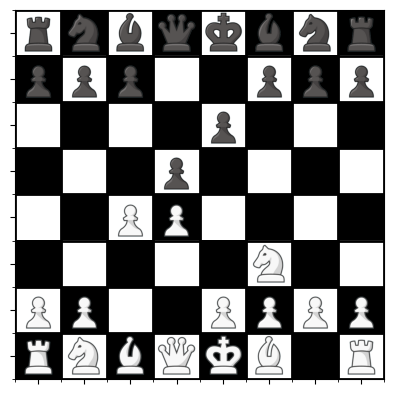

In [133]:
# You can retrieve the game state from the json file
# but don't forget to convert the list to a numpy array
draw_chessboard(np.array(data["game_states"][5]["gs"]), show=True)